# 09 - Hydrological impacts of climate change

## Performing bias correction on climate model data to perform climate change impact studies on hydrology

This notebook will allow evaluating the impacts of climate change on the hydrology of a catchment. We will use the data we previously generated in notebook "08 - Getting and bias-correcting CMIP6 data", where we produced both reference and future forcing datasets.

You can apply this notebook to other models, climate datasets, and generally pick and choose parts of various notebooks to build your own complete workflow.

In [6]:
'''
Import the required packages
'''
import datetime as dt
import xarray as xr

## Simulate the flows on the reference period

In this step, we will take the reference period climate data and run the GR4JCN hydrological model with it. We will then plot a graph to see the streamflow representative of the historical period.

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 1982-06-09
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 1986-06-22
  warn(msg, category=RavenWarning)


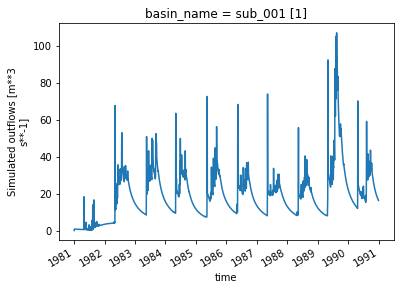

In [7]:
# Need to import the GR4JCN hydrological model instance
from ravenpy.models import GR4JCN

# Start a model instance, in this case a GR4JCN model emulator.
model = GR4JCN()

# Path to the climate data needed to run the Raven model on the reference period.
# All files in your current workspace (the "writable-workspace") can be accessed by adding the "/notebook_dir/writable-workspace/" prefix in the path
# if you need to access data on another folder. For now, we have it in our root.
forcing='reference_dataset.nc'

# Model configuration parameters that will be used for the simulation for both the reference and future periods.
common_run_parameters = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947),
    rain_snow_fraction="RAINSNOW_DINGMAN", 
)

# Run the hydrological model using our forcing data from the reference period, and with the common parameters that will also be used for the future period simulation.
model(
    forcing,
    start_date=dt.datetime(1981,1,1),
    end_date=dt.datetime(1990,12,31),
    **common_run_parameters,
     )

# Now plot the results
model.hydrograph.q_sim.plot()

## Now do the same but for the future period!
We will copy the block of code from above, changing only the file path (from reference dataset to future dataset) as well as the start and end dates.

/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: Initial conditions specified for state variable not in model (DEPRESSION)
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2081-08-25
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2082-04-23
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2083-07-21
  warn(msg, category=RavenWarning)
/opt/conda/envs/birdy/lib/python3.8/site-packages/ravenpy/models/base.py:434: RavenWarning: UpdateHRUForcingFunctions: max_temp<min_temp at gauge: Gauge1 on 2083-07-22
  warn(msg, category=R

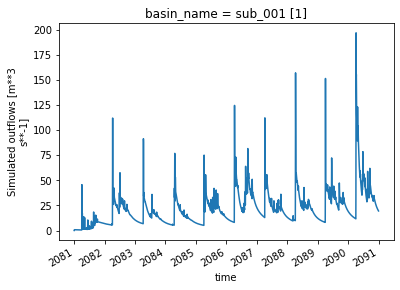

In [8]:
# Now redo the same thing but for the future period.

# Start a new model instance
model = GR4JCN()
params=(0.529, -3.396, 407.29, 1.072, 16.9, 0.947)

# Accessing the future data we just created -- notice it is now the "future_dataset.nc" instead of the "reference_dataset.nc"
forcing='future_dataset.nc'

# Model configuration parameters
model(forcing,
    start_date=dt.datetime(2081,1,1), # Now running the future period!
    end_date=dt.datetime(2090,12,31),
    **common_run_parameters,   
)

# And plot the results! We can compare both figures and see the changes between both.
model.hydrograph.q_sim.plot()

## You have just generated streamflows for the reference and future periods!
We can analyze these hydrographs with many tools in PAVICS-Hydro, or export them to use elsewhere, or use them as inputs to another process!